# Sentiment Analysis on DistilRoBERTa
[michellejieli/emotion_text_classifier](https://huggingface.co/michellejieli/emotion_text_classifier)

### 專題作業時程
#### Sentiment Analysis （3月初）
* Test prompt and optimize 
#### Response Generator （3月底）
* Test prompt and optimize
#### Candidate Generator （4月中）
* Test prompt
* Test different length of history
* Optimize 
* (option) use Trl to strengthen divergence 
#### Similarity Analysis （3月底）
* Find right math formula
* Experiment 
#### Emotion Model （4月底）
* Understand different types of attention mechanism 
* Build model with attention mechanism 
* Optimize
#### Full Model（5月中）
* Optimize and Improve 
* Application
```

### To-Do
* mapping output to dailydialog style
* test performance
* ...

In [1]:
from transformers import pipeline
classifier = pipeline("sentiment-analysis", model="michellejieli/emotion_text_classifier")
classifier("Good.Let ' s go now .")


[{'label': 'neutral', 'score': 0.9622788429260254}]

In [2]:
import torch
torch.cuda.is_available()

True

In [3]:
!nvidia-smi

Tue Mar  5 04:19:39 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0  On |                  N/A |
|  0%   44C    P0   112W / 390W |    495MiB / 24576MiB |     10%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


### preprocessing

In [4]:
import pandas as pd
df = pd.read_parquet('dataset/train-00000-of-00001.parquet')

def map_labels_to_emotions(label):
    emotion_mapping = {
        0: "neutral",
        1: "anger",
        2: "disgust",
        3: "fear",
        4: "joy",
        5: "sadness",
        6: "surprise"
    }
    return emotion_mapping.get(label, "Unknown emotion")

df['emotions'] = df['emotion'].map(map_labels_to_emotions)
df = df.drop('emotion', axis=1)
df = df.drop('turn_type', axis=1)
df.head(20)

,dialog_id,utterance,emotions
0,0,"Say , Jim , how about going for a few beers af...",neutral
1,0,You know that is tempting but is really not g...,neutral
2,0,What do you mean ? It will help us to relax .,neutral
3,0,Do you really think so ? I don't . It will ju...,neutral
4,0,I guess you are right.But what shall we do ? ...,neutral
5,0,I suggest a walk over to the gym where we can...,neutral
6,0,That's a good idea . I hear Mary and Sally of...,joy
7,0,"Sounds great to me ! If they are willing , we...",joy
8,0,Good.Let ' s go now .,joy
9,0,All right .,joy


## Inference


In [5]:
from transformers import pipeline
from datasets import Dataset

classifier = pipeline("sentiment-analysis", model="michellejieli/emotion_text_classifier", device=0)

dataset = Dataset.from_pandas(df.head(300))

def predict(row):
    text = row['utterance']
    true_label = row['emotions']
    
    predicted_result = classifier(text)[0]
    predicted_label = predicted_result["label"]
    
    return {"predicted_label": predicted_label, "true_label": true_label}

predictions = dataset.map(predict)

correct_predictions = sum(1 for p in predictions if p["predicted_label"] == p["true_label"])
total_predictions = len(predictions)
accuracy = correct_predictions / total_predictions

print(f"acc: {accuracy}")



Map:   0%|          | 0/300 [00:00<?, ? examples/s]

/home/user/miniconda3/envs/IS/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


acc: 0.7433333333333333


In [6]:
from transformers import pipeline
from datasets import Dataset

classifier = pipeline("sentiment-analysis", model="michellejieli/emotion_text_classifier", device=0)

dataset = Dataset.from_pandas(df.head(10))

def predict(row):
    text = row['utterance']
    true_label = row['emotions']
    
    predicted_result = classifier(text)[0]
    predicted_label = predicted_result["label"]
    
    print(f"Predicted: {predicted_label}, True: {true_label},        ##Text: {text}")
    return {"predicted_label": predicted_label, "true_label": true_label}

predictions = dataset.map(predict)

correct_predictions = sum(1 for p in predictions if p["predicted_label"] == "neutral")
total_predictions = len(predictions)
accuracy = correct_predictions / total_predictions

print(f"acc: {accuracy}")



Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Predicted: neutral, True: neutral,        ##Text: Say , Jim , how about going for a few beers after dinner ? 
Predicted: neutral, True: neutral,        ##Text:  You know that is tempting but is really not good for our fitness . 
Predicted: neutral, True: neutral,        ##Text:  What do you mean ? It will help us to relax . 
Predicted: anger, True: neutral,        ##Text:  Do you really think so ? I don't . It will just make us fat and act silly . Remember last time ? 
Predicted: sadness, True: neutral,        ##Text:  I guess you are right.But what shall we do ? I don't feel like sitting at home . 
Predicted: neutral, True: neutral,        ##Text:  I suggest a walk over to the gym where we can play singsong and meet some of our friends . 
Predicted: neutral, True: joy,        ##Text:  That's a good idea . I hear Mary and Sally often go there to play pingpong.Perhaps we can make a foursome with them . 
Predicted: joy, True: joy,        ##Text:  Sounds great to me ! If they are willing 

# Fine-tuning

In [7]:
# Model from Hugging Face hub
base_model = "michellejieli/emotion_text_classifier"

# Fine-tuned model
new_model = "emotion_text_classifier_on_dd_v1"

In [8]:
import pandas as pd
df = pd.read_parquet('dataset/train-00000-of-00001.parquet')

def map_labels_to_emotions(label):
    emotion_mapping = {
        0: "neutral",
        1: "anger",
        2: "disgust",
        3: "fear",
        4: "joy",
        5: "sadness",
        6: "surprise"
    }
    return emotion_mapping.get(label, "Unknown emotion")

df['emotions'] = df['emotion'].map(map_labels_to_emotions)
# df = df.drop('emotion', axis=1)
df = df.drop('turn_type', axis=1)

In [9]:
df1 = df
# df1['emotions'] = df1['emotion'].map(map_labels_to_emotions)
df1

,dialog_id,utterance,emotion,emotions
0,0,"Say , Jim , how about going for a few beers af...",0,neutral
1,0,You know that is tempting but is really not g...,0,neutral
2,0,What do you mean ? It will help us to relax .,0,neutral
3,0,Do you really think so ? I don't . It will ju...,0,neutral
4,0,I guess you are right.But what shall we do ? ...,0,neutral
...,...,...,...,...
87165,11116,I want a pair of locus .,0,neutral
87166,11116,"Take a look at the ones on display , please .",0,neutral
87167,11116,I need size 41 .,0,neutral
87168,11117,"Could I have the check , please ?",0,neutral


## Data distribution
[ref:](https://medium.com/@ahmettsdmr1312/fine-tuning-distilbert-for-emotion-classification-84a4e038e90e)

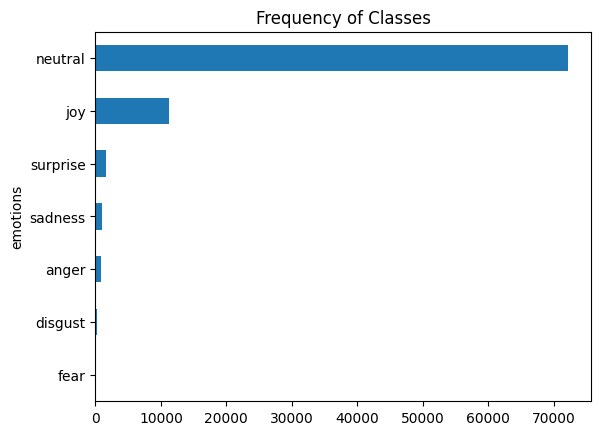

In [10]:
import matplotlib.pyplot as plt

df1["emotions"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

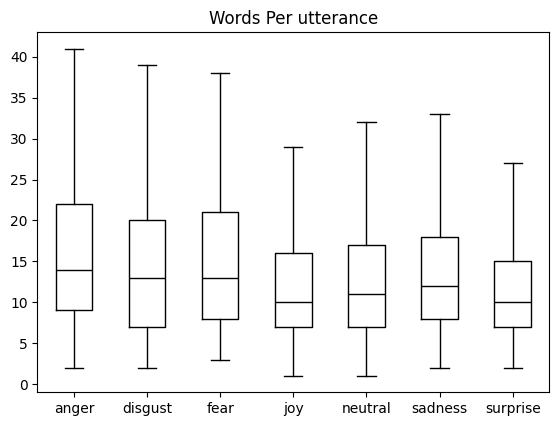

In [11]:
df1["Words Per utterance"] = df1["utterance"].str.split().apply(len)
df1.boxplot("Words Per utterance", by="emotions", grid=False, showfliers=False,
           color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

## issues
1. `The model did not return a loss from the inputs, only the following keys: logits. For reference, the inputs it received are input_ids,attention_mask.`


    如果沒有 df.rename({'utterance': 'text', 'emotions': 'label'}, axis=1)  [好像會讓他讀不到，一定要是這個形式。](https://discuss.huggingface.co/t/the-model-did-not-return-a-loss-from-the-inputs-only-the-following-keys-logits-for-reference-the-inputs-it-received-are-input-values/25420/13)

2. `Unable to create tensor, you should probably activate truncation and/or padding with 'padding=True' 'truncation=True' to have batched tensors with the same length. Perhaps your features (``label`` in this case) have excessive nesting (inputs type ``list`` where type ``int`` is expected).`
   
    這就忘了我的 label 是英文(anger, disgust...)

In [12]:
df = df.drop('Words Per utterance', axis=1)
df = df.drop('dialog_id', axis=1)
df = df.drop('emotions', axis=1)
# somehow this happens.
df = df.rename({'utterance': 'text', 'emotion': 'label'}, axis=1)
df

,text,label
0,"Say , Jim , how about going for a few beers af...",0
1,You know that is tempting but is really not g...,0
2,What do you mean ? It will help us to relax .,0
3,Do you really think so ? I don't . It will ju...,0
4,I guess you are right.But what shall we do ? ...,0
...,...,...
87165,I want a pair of locus .,0
87166,"Take a look at the ones on display , please .",0
87167,I need size 41 .,0
87168,"Could I have the check , please ?",0


In [13]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(base_model)
tokenizer

RobertaTokenizerFast(name_or_path='michellejieli/emotion_text_classifier', vocab_size=50265, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	50264: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False, special=True),
}

In [14]:
def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True)

## About distribution...
  *  Randomly oversample the minority class.
  *  Randomly undersample the majority class.
  *  Gather more labeled data from the underrepresented classes.

這邊第一次先跑 raw 試試看

In [15]:
from datasets import DatasetDict, Dataset
import pandas as pd
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

def convert_to_dataset(df):
    return Dataset.from_pandas(df)

train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)

train_dataset = convert_to_dataset(train_df)
val_dataset = convert_to_dataset(val_df)
test_dataset = convert_to_dataset(test_df)

data_dict = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

print(data_dict)


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 69736
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 8717
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 8717
    })
})


In [16]:
emotions = data_dict

In [17]:
print(tokenize(emotions["train"][:2]))

{'input_ids': [[0, 440, 479, 38, 437, 686, 38, 216, 69, 479, 1437, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [18]:
#hide_input
tokens2ids = list(zip(tokenizer.all_special_tokens, tokenizer.all_special_ids))
data = sorted(tokens2ids, key=lambda x : x[-1])
df = pd.DataFrame(data, columns=["Special Token", "Special Token ID"])
df.T

,0,1,2,3,4
Special Token,<s>,<pad>,</s>,<unk>,<mask>
Special Token ID,0,1,2,3,50264


In [19]:
 # hide_output
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/69736 [00:00<?, ? examples/s]

Map:   0%|          | 0/8717 [00:00<?, ? examples/s]

Map:   0%|          | 0/8717 [00:00<?, ? examples/s]

In [20]:
print(emotions_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


In [21]:
from transformers import AutoModelForSequenceClassification
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# hide_output
num_labels = 7
id2label = {
    0 : "neutral",
    1 : "anger",
    2 : "disgust",
    3 : "fear",
    4 : "joy",
    5 : "sadness",
    6 : "surprise"
}

label2id = {
    "neutral" : 0,
    "anger" : 1,
    "disgust" : 2,
    "fear" : 3,
    "joy" : 4,
    "sadness" : 5,
    "surprise" : 6
}

model = (AutoModelForSequenceClassification
         .from_pretrained(base_model, num_labels=num_labels, id2label=id2label, label2id=label2id)
         .to(device))

In [22]:
model

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (

In [23]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [24]:
# from huggingface_hub import notebook_login

# notebook_login()

In [25]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
# new_model = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=new_model,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True,
                                  log_level="error")

In [26]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train();

  0%|          | 0/2180 [00:00<?, ?it/s]

{'loss': 0.4222, 'learning_rate': 1.0009174311926606e-05, 'epoch': 1.0}


  0%|          | 0/137 [00:00<?, ?it/s]

{'eval_loss': 0.3774647116661072, 'eval_accuracy': 0.8675002867959161, 'eval_f1': 0.8473573275386377, 'eval_runtime': 34.0175, 'eval_samples_per_second': 256.25, 'eval_steps_per_second': 4.027, 'epoch': 1.0}
{'loss': 0.3612, 'learning_rate': 1.834862385321101e-08, 'epoch': 2.0}


  0%|          | 0/137 [00:00<?, ?it/s]

{'eval_loss': 0.37656641006469727, 'eval_accuracy': 0.8631409888723185, 'eval_f1': 0.8541981404878702, 'eval_runtime': 33.9813, 'eval_samples_per_second': 256.524, 'eval_steps_per_second': 4.032, 'epoch': 2.0}
{'train_runtime': 1583.865, 'train_samples_per_second': 88.058, 'train_steps_per_second': 1.376, 'train_loss': 0.39172291640841633, 'epoch': 2.0}


In [27]:
# hide_output
preds_output = trainer.predict(emotions_encoded["validation"])

  0%|          | 0/137 [00:00<?, ?it/s]

In [28]:
preds_output.metrics

{'test_loss': 0.37656641006469727,
 'test_accuracy': 0.8631409888723185,
 'test_f1': 0.8541981404878702,
 'test_runtime': 34.2141,
 'test_samples_per_second': 254.778,
 'test_steps_per_second': 4.004}

In [33]:
from transformers import pipeline
from datasets import Dataset

classifier = pipeline("sentiment-analysis", model=new_model, device=0)

import pandas as pd
df = pd.read_parquet('dataset/train-00000-of-00001.parquet')

# def map_labels_to_emotions(label):
#     emotion_mapping = {
#         0: "neutral",
#         1: "anger",
#         2: "disgust",
#         3: "fear",
#         4: "joy",
#         5: "sadness",
#         6: "surprise"
#     }
#     return emotion_mapping.get(label, "Unknown emotion")

# df['emotions'] = df['emotion'].map(map_labels_to_emotions)
# df = df.drop('emotion', axis=1)
# df = df.drop('turn_type', axis=1)

dataset = Dataset.from_pandas(df.head(3000))

def predict(row):
    text = row['utterance']
    true_label = row['emotion']
    new_model
    predicted_result = classifier(text)[0]
    predicted_label = predicted_result["label"]
    
    print(f"Predicted: {predicted_label}, True: {true_label},        ##Text: {text}")
    return {"predicted_label": predicted_label, "true_label": true_label}

predictions = dataset.map(predict)

correct_predictions = sum(1 for p in predictions if p["predicted_label"] == "neutral")
total_predictions = len(predictions)
accuracy = correct_predictions / total_predictions

print(f"acc: {accuracy}")



Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Predicted: neutral, True: 0,        ##Text: Say , Jim , how about going for a few beers after dinner ? 
Predicted: neutral, True: 0,        ##Text:  You know that is tempting but is really not good for our fitness . 
Predicted: neutral, True: 0,        ##Text:  What do you mean ? It will help us to relax . 
Predicted: neutral, True: 0,        ##Text:  Do you really think so ? I don't . It will just make us fat and act silly . Remember last time ? 
Predicted: neutral, True: 0,        ##Text:  I guess you are right.But what shall we do ? I don't feel like sitting at home . 
Predicted: neutral, True: 0,        ##Text:  I suggest a walk over to the gym where we can play singsong and meet some of our friends . 
Predicted: joy, True: 4,        ##Text:  That's a good idea . I hear Mary and Sally often go there to play pingpong.Perhaps we can make a foursome with them . 
Predicted: joy, True: 4,        ##Text:  Sounds great to me ! If they are willing , we could ask them to go dancing with us.

/home/user/miniconda3/envs/IS/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Predicted: joy, True: 0,        ##Text:  And I love trying new recipes , which I usually test with my friends . You can come , too . 
Predicted: surprise, True: 6,        ##Text:  Really ? I hope I can have a chance to taste it . Don't forget to tell me . 
Predicted: neutral, True: 0,        ##Text:  Certainly . 
Predicted: neutral, True: 0,        ##Text: Anyone home ? Jen ! 
Predicted: neutral, True: 0,        ##Text:  I'm in the kitchen ... let yourself in ! 
Predicted: joy, True: 0,        ##Text:  Wow ! You're really working up a storm ! 
Predicted: neutral, True: 0,        ##Text:  I know . I've even worked up a sweat . 
Predicted: neutral, True: 0,        ##Text:  You look like a cooking show host--only messier . 
Predicted: joy, True: 4,        ##Text: You look so tan and healthy ! 
Predicted: joy, True: 4,        ##Text:  Thanks . I just got back from summer camp . 
Predicted: neutral, True: 0,        ##Text:  How was it ? 
Predicted: joy, True: 4,        ##Text:  Great . I go